# General workflow demonstration

## Setup and configuration

In [1]:
# # Install dependencies not in the base jupyter image and enable the nbextension

# import sys

# !conda install -q -y -c conda-forge --prefix {sys.prefix} ipyleaflet

# # If you have JupyterLab, you will also need to install the JupyterLab extension:
# # !jupyter labextension install @jupyter-widgets/jupyterlab-manager jupyter-leaflet

# !jupyter nbextension enable --py --sys-prefix ipyleaflet

In [2]:
import os
import ipyleaflet
from siphon.catalog import TDSCatalog
from birdy import WPSClient

# we will use these coordinates later to center the map on Canada
canada_center_lat_lon = (52.4292, -93.2959)

#### Pavics url configuration

In [3]:
# Ouranos production server
pavics_url = "https://pavics.ouranos.ca"

# CRIM test server
# Important note: this is a development server, uptime is not guaranteed
# pavics_url = "https://colibri.crim.ca"

finch_url = os.getenv("WPS_URL")
if not finch_url:
    finch_url = f"{pavics_url}/twitcher/ows/proxy/finch/wps"

## Getting user input from a map widget

### Notes about ipyleaflet

ipyleaflet is a **"A Jupyter / Leaflet bridge enabling interactive maps in the Jupyter notebook"**

This means that the interactions with graphical objects on the map and in python are synchronized. The documentation is at: https://ipyleaflet.readthedocs.io

In [4]:
leaflet_map = ipyleaflet.Map(
    center=canada_center_lat_lon,
    basemap=ipyleaflet.basemaps.Stamen.Terrain,
    zoom=4,
)

initial_marker_location = canada_center_lat_lon
marker = ipyleaflet.Marker(location=initial_marker_location, draggable=True)
leaflet_map.add_layer(marker)

leaflet_map

Map(center=[52.4292, -93.2959], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'z…

If you move the marker on the map, it will update the `marker.location` variable. Also, if you update `marker.location` manually (`marker.location = (45.44, -90.44)`) it will also move on the map.

In [5]:
marker.location = (45.55, -72.44)

In [6]:
print(initial_marker_location)
print(marker.location)

(52.4292, -93.2959)
[45.55, -72.44]


#### Helper function to get user input

In [7]:
import ipyleaflet
from IPython.display import display
import ipywidgets as widgets


def get_rectangle():
    canada_center = (52.4292, -93.2959)
    m = ipyleaflet.Map(
        center=canada_center,
        basemap=ipyleaflet.basemaps.Stamen.Terrain,
        zoom=4,
    )

    # Create a new draw control
    draw_control = ipyleaflet.DrawControl()

    # disable some drawing inputs
    draw_control.polyline = {}
    draw_control.circlemarker = {}
    draw_control.polygon = {}

    draw_control.rectangle = {
        "shapeOptions": {
            "fillColor": "#4ae",
            "color": "#4ae",
            "fillOpacity": 0.3,
        }
    }

    output = widgets.Output(layout={"border": "1px solid black"})

    rectangle = {}

    # set drawing callback
    def callback(control, action, geo_json):
        if action == "created":
            # note: we can't close the map or remove it from the output
            # from this callback. The map keeps the focus, and the
            # jupyter keyboard input is messed up.
            # So we set it very thin to make it disappear :)
            m.layout = {"max_height": "0"}
            with output:
                print("*User selected 1 rectangle*")
                rectangle.update(geo_json)

    draw_control.on_draw(callback)

    m.add_control(draw_control)

    with output:
        print("Select a rectangle:")
        display(m)

    display(output)

    return rectangle

#### The user wants to select a rectangle on a map, and get a GeoJSON back

In [8]:
# NBVAL_IGNORE_OUTPUT

rectangle = get_rectangle()

Output(layout=Layout(border='1px solid black'))

In [9]:
#  GeoJSON with custom style properties
if not len(rectangle):
    # Use the default region of Greater Montreal Area
    rectangle = {
        "type": "Feature",
        "properties": {
            "style": {
                "stroke": True,
                "color": "#4ae",
                "weight": 4,
                "opacity": 0.5,
                "fill": True,
                "fillColor": "#4ae",
                "fillOpacity": 0.3,
                "clickable": True,
            }
        },
        "geometry": {
            "type": "Polygon",
            "coordinates": [
                [
                    [-74.511948, 45.202296],
                    [-74.511948, 45.934852],
                    [-72.978537, 45.934852],
                    [-72.978537, 45.202296],
                    [-74.511948, 45.202296],
                ]
            ],
        },
    }
rectangle

{'type': 'Feature',
 'properties': {'style': {'stroke': True,
   'color': '#4ae',
   'weight': 4,
   'opacity': 0.5,
   'fill': True,
   'fillColor': '#4ae',
   'fillOpacity': 0.3,
   'clickable': True}},
 'geometry': {'type': 'Polygon',
  'coordinates': [[[-74.511948, 45.202296],
    [-74.511948, 45.934852],
    [-72.978537, 45.934852],
    [-72.978537, 45.202296],
    [-74.511948, 45.202296]]]}}

#### Get the maximum and minimum bounds

In [10]:
import geopandas as gpd

rect = gpd.GeoDataFrame.from_features([rectangle])
bounds = rect.bounds
bounds

,minx,miny,maxx,maxy
0,-74.511948,45.202296,-72.978537,45.934852


## Calling wps processes

For this example, we will **subset** a dataset with the user-selected bounds, and launch a **heat wave frequency** analysis on it.

In [11]:
finch = WPSClient(finch_url, progress=False)

In [12]:
help(finch.subset_bbox)

Help on method subset_bbox in module birdy.client.base:

subset_bbox(resource=None, lon0=0.0, lon1=360.0, lat0=-90.0, lat1=90.0, start_date=None, end_date=None, variable=None) method of birdy.client.base.WPSClient instance
    Return the data for which grid cells intersect the bounding box for each input dataset as well as the time range selected.
    
    Parameters
    ----------
    resource : ComplexData:mimetype:`application/x-netcdf`, :mimetype:`application/x-ogc-dods`
        NetCDF files, can be OPEnDAP urls.
    lon0 : float
        Minimum longitude.
    lon1 : float
        Maximum longitude.
    lat0 : float
        Minimum latitude.
    lat1 : float
        Maximum latitude.
    start_date : string
        Initial date for temporal subsetting. Can be expressed as year (%Y), year-month (%Y-%m) or year-month-day(%Y-%m-%d). Defaults to first day in file.
    end_date : string
        Final date for temporal subsetting. Can be expressed as year (%Y), year-month (%Y-%m) or year

### Subset tasmin and tasmax datasets

In [13]:
# gather data from pavics' data catalogue
catalog = "https://pavics.ouranos.ca/twitcher/ows/proxy/thredds/catalog/datasets/gridded_obs/catalog.xml"  # TEST_USE_PROD_DATA

cat = TDSCatalog(catalog)
data = cat.datasets[0].access_urls["OPENDAP"]
data

'https://pavics.ouranos.ca/twitcher/ows/proxy/thredds/dodsC/datasets/gridded_obs/nrcan_v2.ncml'

In [14]:
# NBVAL_IGNORE_OUTPUT

# If we want a preview of the data, here's what it looks like:
import xarray as xr

ds = xr.open_dataset(data, chunks="auto")
ds

,Array,Chunk
Bytes,50.40 GiB,127.96 MiB
Shape,"(24837, 510, 1068)","(7390, 51, 89)"
Count,481 Tasks,480 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,50.40 GiB,127.96 MiB
Shape,"(24837, 510, 1068)","(7390, 51, 89)"
Count,481 Tasks,480 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


In [15]:
lon0 = float(bounds.minx)
lon1 = float(bounds.maxx)
lat0 = float(bounds.miny)
lat1 = float(bounds.maxy)

result_tasmin = finch.subset_bbox(
    resource=data,
    variable="tasmin",
    lon0=lon0,
    lon1=lon1,
    lat0=lat0,
    lat1=lat1,
    start_date="1958-01-01",
    end_date="1958-12-31",
)

In [16]:
# wait for process to complete before running this cell (the process is async)
tasmin_subset = result_tasmin.get().output
tasmin_subset

'https://host-140-91.rdext.crim.ca/wpsoutputs/0677460a-1b1e-11ec-8812-55fea68da9e0/nrcan_v2_sub.ncml'

In [17]:
result_tasmax = finch.subset_bbox(
    resource=data,
    variable="tasmax",
    lon0=lon0,
    lon1=lon1,
    lat0=lat0,
    lat1=lat1,
    start_date="1958-01-01",
    end_date="1958-12-31",
)

In [18]:
# wait for process to complete before running this cell (the process is async)
tasmax_subset = result_tasmax.get().output
tasmax_subset

'https://host-140-91.rdext.crim.ca/wpsoutputs/0ab2e94f-1b1e-11ec-85dd-55fea68da9e0/nrcan_v2_sub.ncml'

### Launch a heat wave frequency analysis with the subsetted datasets

In [19]:
help(finch.heat_wave_frequency)

Help on method heat_wave_frequency in module birdy.client.base:

heat_wave_frequency(tasmin=None, tasmax=None, thresh_tasmin='22.0 degC', thresh_tasmax='30 degC', window=3, freq='YS', check_missing='any', missing_options=None, cf_compliance='warn', data_validation='raise', variable=None) method of birdy.client.base.WPSClient instance
    Number of heat waves over a given period. A heat wave is defined as an event where the minimum and maximum daily temperature both exceeds specific thresholds over a minimum number of days.
    
    Parameters
    ----------
    tasmin : ComplexData:mimetype:`application/x-netcdf`, :mimetype:`application/x-ogc-dods`
        NetCDF Files or archive (tar/zip) containing netCDF files. Minimum surface temperature.
    tasmax : ComplexData:mimetype:`application/x-netcdf`, :mimetype:`application/x-ogc-dods`
        NetCDF Files or archive (tar/zip) containing netCDF files. Maximum surface temperature.
    thresh_tasmin : string
        The minimum temperature

In [20]:
result = finch.heat_wave_frequency(
    tasmin=tasmin_subset,
    tasmax=tasmax_subset,
    thresh_tasmin="14 degC",
    thresh_tasmax="22 degC",
)

Get the output as a python object (xarray Dataset)

In [21]:
response = result.get(asobj=True)

syntax error, unexpected WORD_WORD, expecting SCAN_ATTR or SCAN_DATASET or SCAN_ERROR
context: <html^><head><title>404 Not Found</title></head><body bgcolor="white"><center><h1>404 Not Found</h1></center><hr><center>nginx/1.13.6</center></body></html>


In [22]:
ds = response.output_netcdf

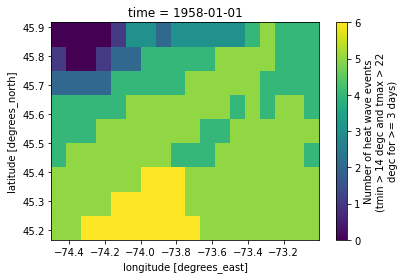

In [23]:
ds.heat_wave_frequency.plot()

### Showing wms layers on a map (TODO)

The results are stored in a folder that is available to thredds, which provides a WMS service to its datasets. In the case of large outputs, the user could view ths results of the analysis as a wms service without downloading the data.

#### Get the wms url from the 'wpsoutputs'

In [24]:
output_url = result.get().output_netcdf
print("output_url = ", output_url)
output_path = output_url[output_url.find("wpsoutputs") :]
output_path = output_path.replace("wpsoutputs", "wps_outputs")
print("output_path = ", output_path)

output_thredds_url = f"{pavics_url}:8083/thredds/wms/birdhouse/{output_path}"
output_thredds_url

output_url =  https://host-140-91.rdext.crim.ca/wpsoutputs/0eca243a-1b1e-11ec-ad67-55fea68da9e0/out.nc
output_path =  wps_outputs/0eca243a-1b1e-11ec-ad67-55fea68da9e0/out.nc


'https://host-140-91.rdext.crim.ca:8083/thredds/wms/birdhouse/wps_outputs/0eca243a-1b1e-11ec-ad67-55fea68da9e0/out.nc'

Using ipyleaflet again, we can connect to this wms service.

In [25]:
def show_wms(url):
    canada_center = (52.4292, -93.2959)

    wms = ipyleaflet.WMSLayer(
        url=url,
        layers="heat_wave_frequency",
        styles="boxfill/ferret",
        format="image/png",
        transparent=True,
        opacity=1,
        version="1.3.0",
    )
    basemap_layer = ipyleaflet.basemap_to_tiles(ipyleaflet.basemaps.Stamen.Terrain)
    m = ipyleaflet.Map(
        layers=(basemap_layer, wms),
        center=canada_center,
        zoom=4,
    )
    return m


m = show_wms(output_thredds_url)
m

Map(center=[52.4292, -93.2959], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'z…